In [1]:
import sys
import pathlib
lime_dir = pathlib.Path.cwd().parent.parent
sys.path.append(str(lime_dir))

In [2]:
from lime.lime_text import TextLIME
from lime.indexers import StringTokenizer, NgramTokenizer

In [3]:
import numpy as np

# NN model

In [4]:
from torchtext.datasets import AG_NEWS
train_iter = AG_NEWS(split='train')

In [5]:
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

tokenizer = get_tokenizer('basic_english')
train_iter = AG_NEWS(split='train')
counter = Counter()
for (label, line) in train_iter:
    counter.update(tokenizer(line))
vocab = Vocab(counter, min_freq=1)


text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
label_pipeline = lambda x: int(x) - 1

In [6]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

train_iter = AG_NEWS(split='train')
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [7]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [8]:
train_iter = AG_NEWS(split='train')
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [9]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predited_label = model(text, offsets)
            loss = criterion(predited_label, label)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [10]:
from torch.utils.data.dataset import random_split
# Hyperparameters
EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
train_iter, test_iter = AG_NEWS()
train_dataset = list(train_iter)
test_dataset = list(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/ 1782 batches | accuracy    0.683
| epoch   1 |  1000/ 1782 batches | accuracy    0.854
| epoch   1 |  1500/ 1782 batches | accuracy    0.878
-----------------------------------------------------------
| end of epoch   1 | time:  8.49s | valid accuracy    0.890 
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.897
| epoch   2 |  1000/ 1782 batches | accuracy    0.902
| epoch   2 |  1500/ 1782 batches | accuracy    0.903
-----------------------------------------------------------
| end of epoch   2 | time:  7.69s | valid accuracy    0.894 
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.915
| epoch   3 |  1000/ 1782 batches | accuracy    0.914
| epoch   3 |  1500/ 1782 batches | accuracy    0.913
-----------------------------------------------------------
| end of epoch   3 | time:  8.34s | valid accuracy    0.896 
-------------------------------

# LIME

In [11]:
def get_sample_predictions(text):
    ag_news_label = {1: "World",
                     2: "Sports",
                     3: "Business",
                     4: "Sci/Tec"}
    prediction_probs = []
    pred = []
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text.cuda(), torch.tensor([0]).cuda())
    # The output has unnormalized scores. To get probabilities, run a softmax on it.
    prediction_probs.append(torch.nn.functional.softmax(output[0], dim=0))
    res = output.argmax(1).item()
    pred.append(res + 1)
    prediction_probs = np.array([i.cpu().numpy() for i in prediction_probs])
    return prediction_probs[0]

In [12]:
ex_text_str2 = """
    GameStop shares plunged Wednesday after the long-struggling Grapevine, 
    Texas-based gameseller reported earnings that failed to impress analysts, 
    but the firm's new ecommerce push prompted one expert to release Wall Street's most bullish price target,
    marking the first analyst to say that a turnaround could actually justify GameStop's meteoric valuation.
""".strip().replace('\n', '')

In [13]:
get_sample_predictions(ex_text_str2)

array([6.5475881e-02, 1.2945544e-04, 3.4906629e-01, 5.8532840e-01],
      dtype=float32)

In [14]:
indexer = StringTokenizer(tokenizer)
exp = TextLIME(indexer=indexer, neighbour_version='one_off', neighbour_parameter=4)

out = exp.explain_instance(ex_text_str2, get_sample_predictions, num_samples=2, labels=(2,))

In [15]:
out.describe()[2]['prediction_score']

0.6287321332017216

# Test - part 1
* Number of samples (neighbors)
* Number/fraction of active tokens
* Presence of weights
    * Kernel width and kernel multiplier
    * Distance metric
* Explainable family of models
* Alpha penalty in feature selection

**Me:** num sampels, precense of weights + modifications<br>
**Fillip:** feature selection, simple models

**Both:** Find two example news stories appx 4 lines and do annotation on positive words (I do world and sceince)


In [16]:
%load_ext autoreload
%autoreload 2

In [17]:
del TextLIME
from lime.lime_text import TextLIME

del NgramTokenizer
from lime.indexers import StringTokenizer, NgramTokenizer

In [18]:
def get_sample_predictions(text):
    ag_news_label = {1: "World",
                     2: "Sports",
                     3: "Business",
                     4: "Sci/Tec"}
    prediction_probs = []
    pred = []
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text.cuda(), torch.tensor([0]).cuda())
    # The output has unnormalized scores. To get probabilities, run a softmax on it.
    prediction_probs.append(torch.nn.functional.softmax(output[0], dim=0))
    res = output.argmax(1).item()
    pred.append(res + 1)
    prediction_probs = np.array([i.cpu().numpy() for i in prediction_probs])
    return prediction_probs[0]

In [19]:
ex_world = """
    Australia has scrapped agreements tied to China's Belt and Road initiative, 
    prompting anger from Beijing and adding further strain to tense relations between the countries. 
    The federal government used new powers to rip up two deals made between the state of Victoria and China.
    Canberra said it was backing away from the agreements to protect Australia's national interest.
""".strip().replace('\n', '')

ex_world_pos1 = """
    agreements initiative tense relations countries federal government powers deals state agreements protect national interest
""".strip().replace('\n', '').split(" ")

ex_world_pos2 = """
    australia china beijing victoria china canberra australia
""".strip().replace('\n', '').split(" ")

In [20]:
ex_science = """
    Imagine wearing high-tech body armour that makes you super strong and tireless.
    Such technology, more specifically called an exoskeleton, sounds like the preserve of the Iron Man series of superhero movies.
    Yet the equipment is increasingly being worn in real life around the world. And one manufacturer - California's SuitX - expects it to go mainstream.
    In simple terms, an exoskeleton is an external device that supports, covers and protects its user, giving greater levels of strength and endurance.
""".strip().replace('\n', '')

ex_science_pos = """
    high-tech strong technology equipment real life manufacturer expects external device protects user levels strength
""".strip().replace('\n', '').split(" ")

In [21]:
import matplotlib.pyplot as plt
import itertools
plt.rcParams['figure.figsize'] = [15, 10]

In [22]:
outs = {}

In [23]:
def reformat_outs(text, settings, outs=outs, genre=0, min_importance=0.01, indexer=indexer):
    text_array = np.array(indexer(text))
    index_list = []
    word_list = []
    
    for setting_a, setting_b in settings:
        tmp = np.array(outs[setting_a][setting_b].describe()[genre]['feature_importance'])
        coefs = tmp[:,1]
        large_coefs_idx = np.argwhere(coefs >= min_importance).ravel()
        word_idx = tmp[:,0][large_coefs_idx].astype(np.int)
        word_idx.sort()
        
        isalpha_idx = [i.isalpha() for i in text_array[word_idx]] #Removes different puntuation
        index_list.append(word_idx[isalpha_idx])
        word_list.append(text_array[word_idx][isalpha_idx])
    return index_list, word_list

def reformat_anno(text, annotation, indexer=indexer):
    text = [i.replace('-','') for i in indexer(text)]
    annotation = [i.replace('-','') for i in annotation]
    index_list = list(set([text.index(i) for i in annotation]))
    index_list.sort()
    return index_list, annotation

def compare_outs(lis1, lis2):
    l1 = set(lis1)
    l2 = set(lis2)
    inter = l1.intersection(l2)
    union = l1.union(l2)
    try:
        IoU = len(inter)/len(union)
    except ZeroDivisionError:
        IoU = 0
    return IoU

In [24]:
dict_labels = {0: "World",
               1: "Sports",
               2: "Business",
               3: "Sci/Tec"}

### Test 1: Num_samples + presence of weights  
**Science**

In [44]:
param_ker = [True, False]
param_sap = [2**i for i in range(4,10)]

text = ex_science
annotation = ex_science_pos

In [64]:
indexer = StringTokenizer(tokenizer)

outs = {}
for p_ker in param_ker:
    outs['p_ker:'+str(p_ker)] = {}
    for p_sap in param_sap:
        LIME_exp = TextLIME(indexer=indexer,
                    kernel_active=p_ker,
                    feature_selection=None)

        out = LIME_exp.explain_instance(text,
                                        get_sample_predictions,
                                        labels=(0,1,2,3), 
                                        num_samples=p_sap)
        outs['p_ker:'+str(p_ker)]['p_sap:'+str(p_sap)] = out

In [46]:
for p_sap in param_sap:
    print('psap:',p_sap)
    for p_ker in param_ker:
        display(outs['p_ker:'+str(p_ker)]['p_sap:'+str(p_sap)].visualize_text({3: "Sci/Tec"}, 0.02))

psap: 16


psap: 32


psap: 64


psap: 128


psap: 256


psap: 512


### For small sample size the explainations differ a lot between kernel active/inactive, but for larger sample size it gets more robust to the point that it is not important. But it is difficult to say that one is better than the other

In [47]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.figsize'] = [8, 5]

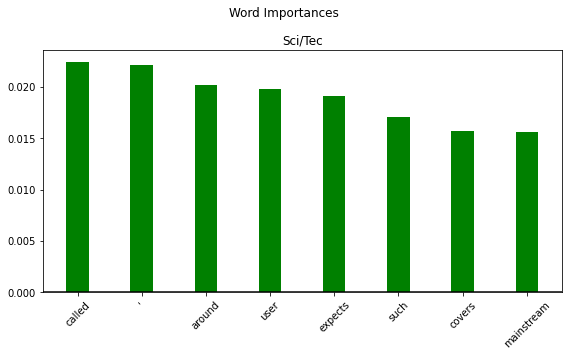

None

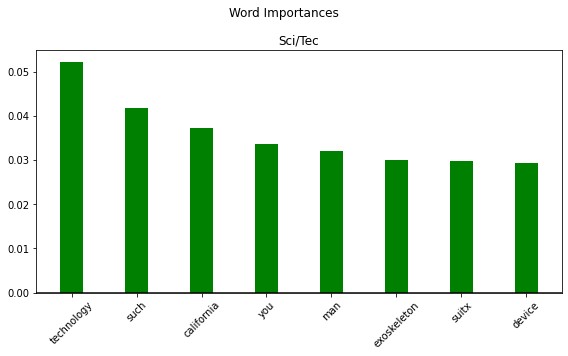

None

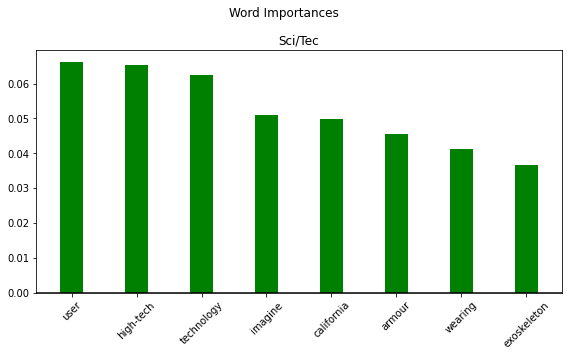

None

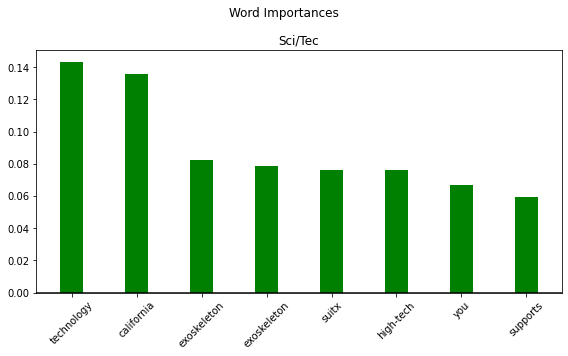

None

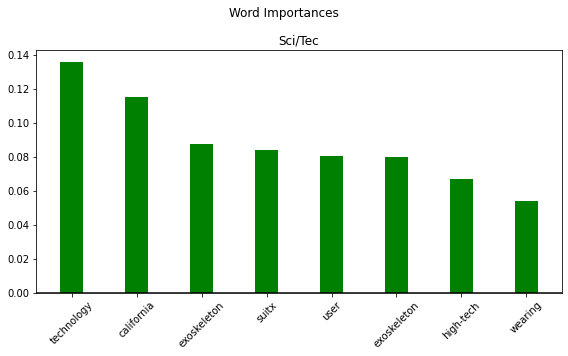

None

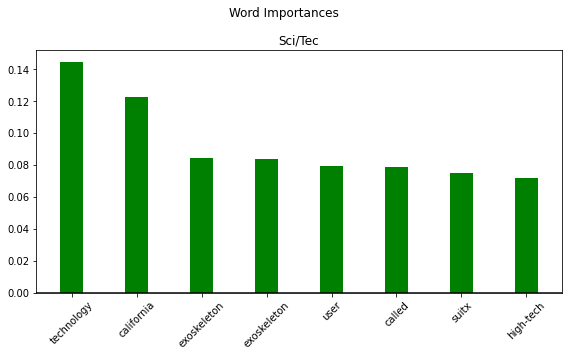

None

In [48]:
for p_sap in param_sap:
    display(outs['p_ker:'+str(True)]['p_sap:'+str(p_sap)].visualize_words({3: "Sci/Tec"}, 8, show_coefs='positive'))

In [49]:
print(list(itertools.product(param_ker, param_sap)))

[(True, 16), (True, 32), (True, 64), (True, 128), (True, 256), (True, 512), (False, 16), (False, 32), (False, 64), (False, 128), (False, 256), (False, 512)]


In [66]:
#settings1 = [('p_ker:'+str(p_ker),'p_sap:'+str(p_sap)) for p_ker,p_sap in itertools.product(param_ker,param_sap)]
settings = [('p_ker:'+str(p_ker), 'p_sap:'+str(p_sap)) for p_ker, p_sap in itertools.product(param_ker, param_sap)]
idx, wrd = reformat_outs(text, settings, outs=outs, genre=3)
idx_anno, new_anno = reformat_anno(text, annotation)

<ipython-input-62-6c3148839dfe>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  word_idx = tmp[:,0][large_coefs_idx].astype(np.int)


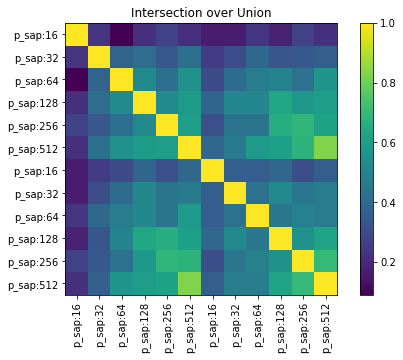

In [67]:
plot_array = np.ones((len(settings),len(settings)))
for i,j in itertools.permutations(range(len(settings)), 2):
    plot_array[i,j] = compare_outs(idx[i], idx[j])
plt.imshow(plot_array)
plt.colorbar()
plt.title('Intersection over Union')
l=list(range(len(settings)))
x=[settings[i][1] for i in range(len(settings))]

plt.gca().set_xticks(l)
plt.gca().set_xticklabels(x, rotation=90)
plt.gca().set_yticks(l)
plt.gca().set_yticklabels(x)
plt.show()

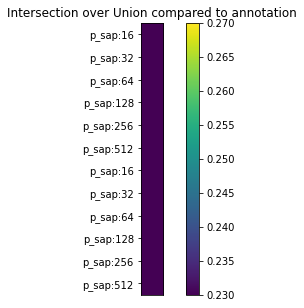

In [68]:
plot_array = np.ones((len(settings),1))
for i in range(len(settings)):
    plot_array[i] = compare_outs(idx[i], idx_anno)
plt.imshow(plot_array, vmax = 0.27, vmin = 0.23)
plt.colorbar()
plt.title('Intersection over Union compared to annotation')
l=list(range(len(settings)))
x=[settings[i][1] for i in range(len(settings))]

plt.gca().set_yticks(l)
plt.gca().set_yticklabels(x)
plt.gca().set_xticks([1])
plt.show()

### Test 2: Feature Selection + alpha penalty
Num_samples: $2^{10}$ <br>
kernel_active: False <br>
**Science**

In [69]:
param_ker = False
param_sap = 2**10
param_feature = ['forward_selection', 'highest_weights']
param_alpha = [0, 0.01, 0.1, 1, 10]

text = ex_science
annotation = ex_science_pos

In [70]:
indexer = StringTokenizer(tokenizer)

outs = {}
for p_feat in param_feature:
    outs['p_feat:'+str(p_feat)] = {}
    for p_alpha in param_alpha:
        LIME_exp = TextLIME(indexer=indexer,
                    kernel_active=p_ker,
                    feature_selection=p_feat,
                    alpha_penalty=p_alpha)

        out = LIME_exp.explain_instance(text,
                                        get_sample_predictions,
                                        labels=(0,1,2,3), 
                                        num_samples=p_sap)
        outs['p_feat:'+str(p_feat)]['p_alpha:'+str(p_alpha)] = out

In [71]:
for p_feat in param_feature:
    for p_alpha in param_alpha:
        print('p_feat:',p_feat, 'p_alpha:', p_alpha)
        display(outs['p_feat:'+str(p_feat)]['p_alpha:'+str(p_alpha)].visualize_text({3: "Sci/Tec"}, 0.02))

p_feat: forward_selection p_alpha: 0


p_feat: forward_selection p_alpha: 0.01


p_feat: forward_selection p_alpha: 0.1


p_feat: forward_selection p_alpha: 1


p_feat: forward_selection p_alpha: 10


p_feat: highest_weights p_alpha: 0


p_feat: highest_weights p_alpha: 0.01


p_feat: highest_weights p_alpha: 0.1


p_feat: highest_weights p_alpha: 1


p_feat: highest_weights p_alpha: 10


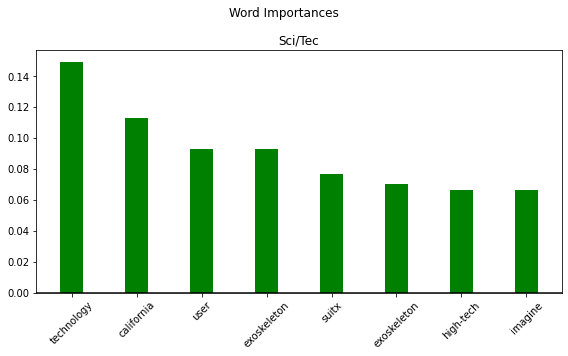

None

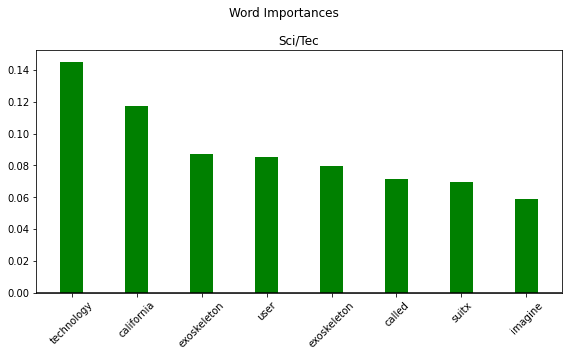

None

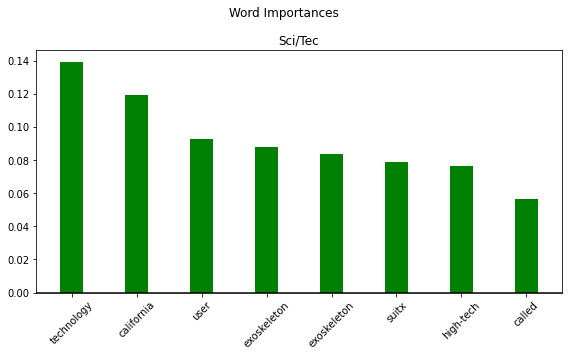

None

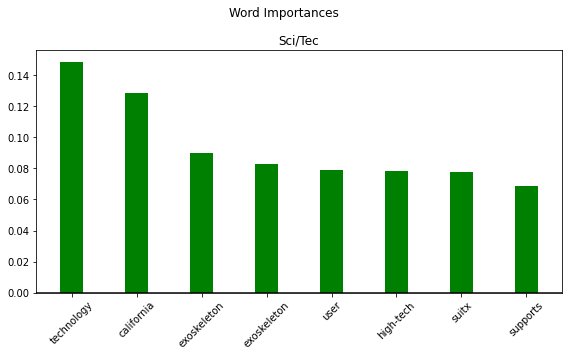

None

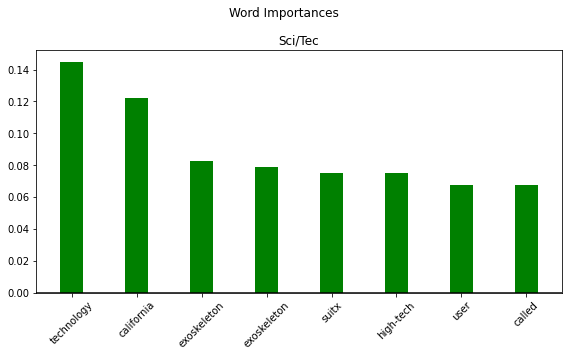

None

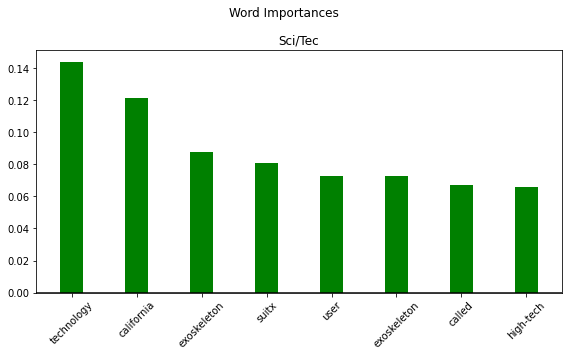

None

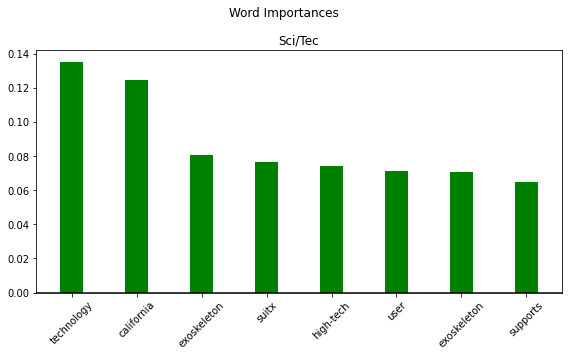

None

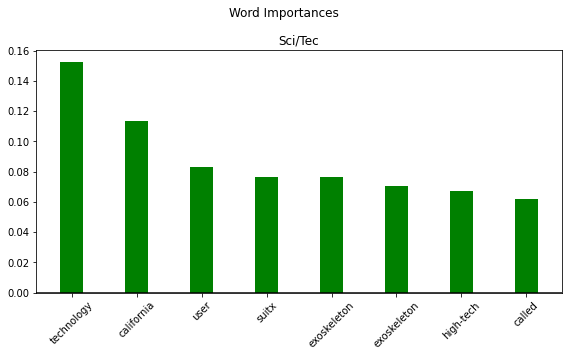

None

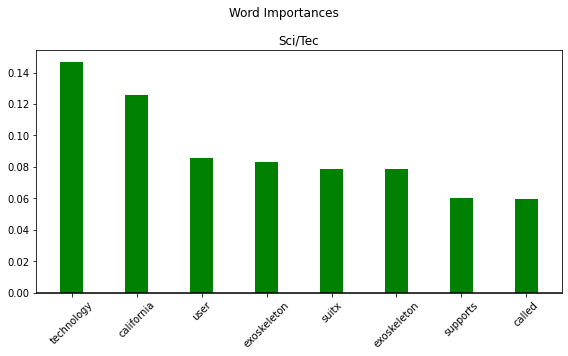

None

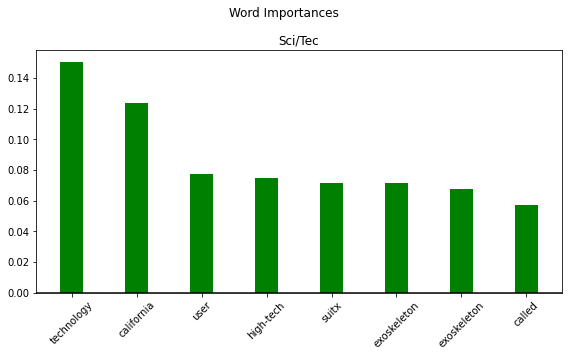

None

In [72]:
for p_feat in param_feature:
    for p_alpha in param_alpha:
        display(outs['p_feat:'+str(p_feat)]['p_alpha:'+str(p_alpha)].visualize_words({3: "Sci/Tec"}, 8, show_coefs='positive'))

In [75]:
#settings1 = [('p_feat:'+str(p_feat),'p_alpha:'+str(p_alpha)) for p_feat,p_alpha in itertools.product(param_feature,param_alpha)]
settings = [('p_feat:'+str(p_feat),'p_alpha:'+str(p_alpha)) for p_feat,p_alpha in itertools.product(param_feature,param_alpha)]
idx, wrd = reformat_outs(text, settings, outs=outs, genre=3)
idx_anno, new_anno = reformat_anno(text, annotation)

<ipython-input-62-6c3148839dfe>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  word_idx = tmp[:,0][large_coefs_idx].astype(np.int)


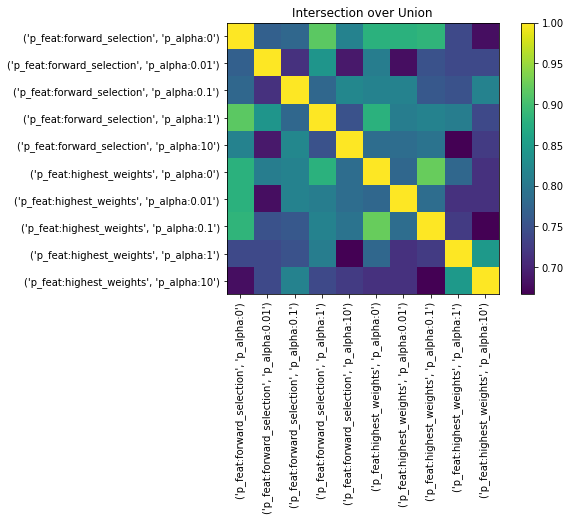

In [76]:
plot_array = np.ones((len(settings),len(settings)))
for i,j in itertools.permutations(range(len(settings)), 2):
    plot_array[i,j] = compare_outs(idx[i], idx[j])
plt.imshow(plot_array)
plt.colorbar()
plt.title('Intersection over Union')
l=list(range(len(settings)))
x=[settings[i] for i in range(len(settings))]

plt.gca().set_xticks(l)
plt.gca().set_xticklabels(x, rotation=90)
plt.gca().set_yticks(l)
plt.gca().set_yticklabels(x)
plt.show()

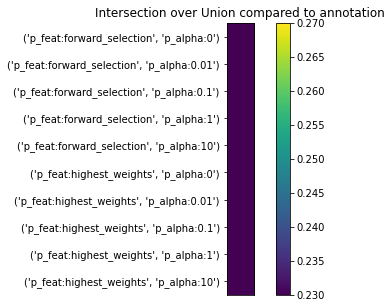

In [77]:
plot_array = np.ones((len(settings),1))
for i in range(len(settings)):
    plot_array[i] = compare_outs(idx[i], idx_anno)
plt.imshow(plot_array, vmax = 0.27, vmin = 0.23)
plt.colorbar()
plt.title('Intersection over Union compared to annotation')
l=list(range(len(settings)))
x=[settings[i] for i in range(len(settings))]

plt.gca().set_yticks(l)
plt.gca().set_yticklabels(x)
plt.gca().set_xticks([1])
plt.show()

### Test 3: Simple model
kernel_active: True <br>
feature_selection: 'highest_weights'<br>
**Science**

In [56]:
param_model = [
    'ridge_0.01', # 'ridge_0.1', 'ridge_1', 'ridge_10',
    'lasso_0.001', # 'lasso_0.01', 'lasso_0.1'
    'svr_c_1', # 'svr_c_0.1', 'svr_c_10', 'svr_c_100',
    'tree_ss_2_md_None', # 'tree_ss_2_md_3', 'tree_ss_2_md_5', 'tree_ss_5_md_None',
    'rf'
]
# lasso 0.25-10 is invalid
text = ex_science
annotation = ex_science_pos

Ridge:
- Lightly penalizes coefficients (larger penalty -> less words)
- Takes a lot of words
- Quite robust option as long as the parameter is not extreme

Lasso:
- Heavily penalizes coeficients (larger penalty -> less words)

SVR:
- Cannot clearly decide on C parameter as differences are hard to interpret
- Similar to Ridge Regression

Tree:
- default one performs the best
- only positive words (coefs) and very selective, takes only a few words

Random Forest:
- Has similar (but worse) output to tree based regressor
- Requires more computational power

In [61]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [62]:
import warnings
warnings.simplefilter("ignore")

In [65]:
indexer = StringTokenizer(tokenizer)

outs = {'temp': {}}
for p_model in param_model:
    outs['temp']['p_model:'+str(p_model)] = {}
    
    simple_model = None
    if 'ridge' in p_model:
        penalty = float(p_model.split('_')[1])
        simple_model = Ridge(alpha=penalty, random_state=123)
    if 'lasso' in p_model:
        penalty = float(p_model.split('_')[1])
        simple_model = Lasso(alpha=penalty, random_state=123)
    if 'svr' in p_model:
        regularization = float(p_model.split('_')[2])
        simple_model = LinearSVR(C=regularization, random_state=123)
    if 'tree' in p_model:
        sample_split = int(p_model.split('_')[2])
        max_depth = p_model.split('_')[-1]
        max_depth = int(max_depth) if max_depth != 'None' else None
        simple_model = DecisionTreeRegressor(
            min_samples_split=sample_split, max_depth=max_depth, random_state=123)
    if 'rf' in p_model:
        simple_model = RandomForestRegressor()
    
    LIME_exp = TextLIME(indexer=indexer, simple_model=simple_model, kernel_active=False)

    out = LIME_exp.explain_instance(text,
                                    get_sample_predictions,
                                    labels=(0,1,2,3),
                                    num_samples=2**10)
    outs['temp']['p_model:'+str(p_model)] = out

In [66]:
for p_model in param_model:
    print('model:', p_model)
    display(outs['temp']['p_model:'+str(p_model)].visualize_text({3: "Sci/Tec"}, 0.02))

model: ridge_0.01


model: lasso_0.001


model: svr_c_1


model: tree_ss_2_md_None


model: rf


model: ridge_0.01


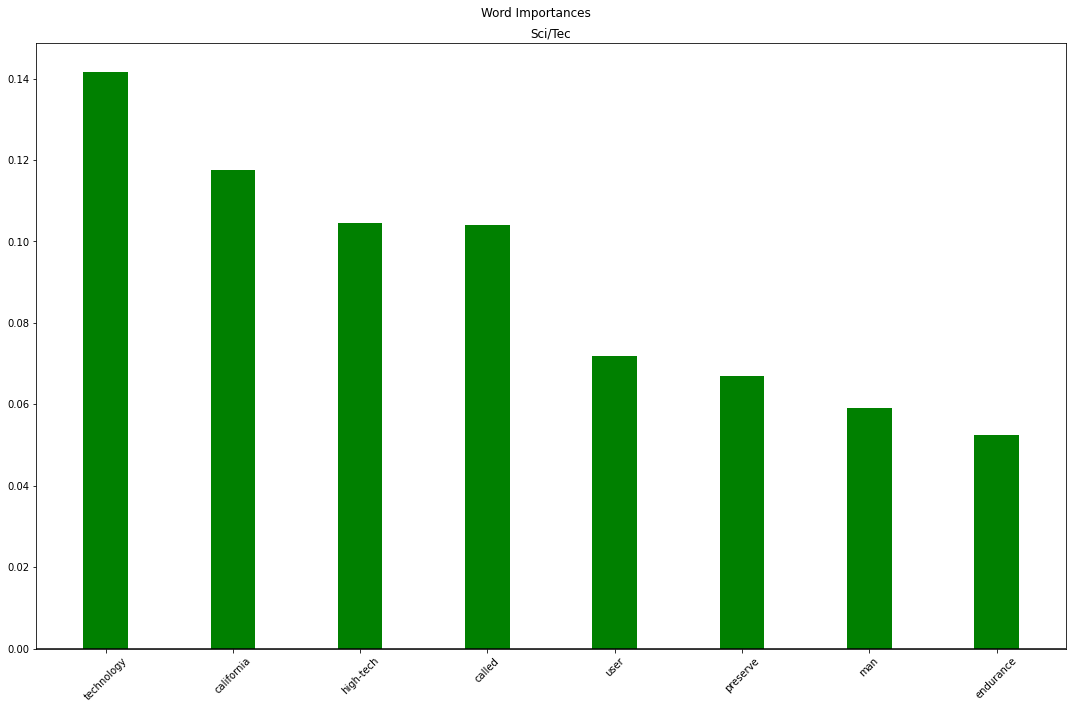

None

model: lasso_0.001


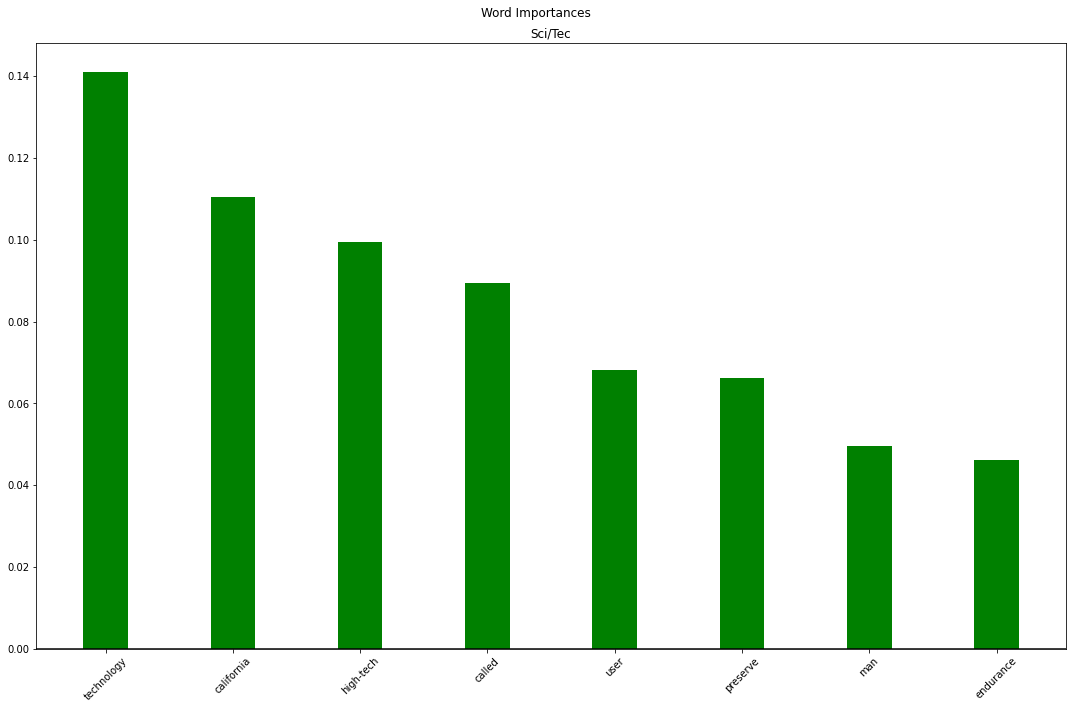

None

model: svr_c_1


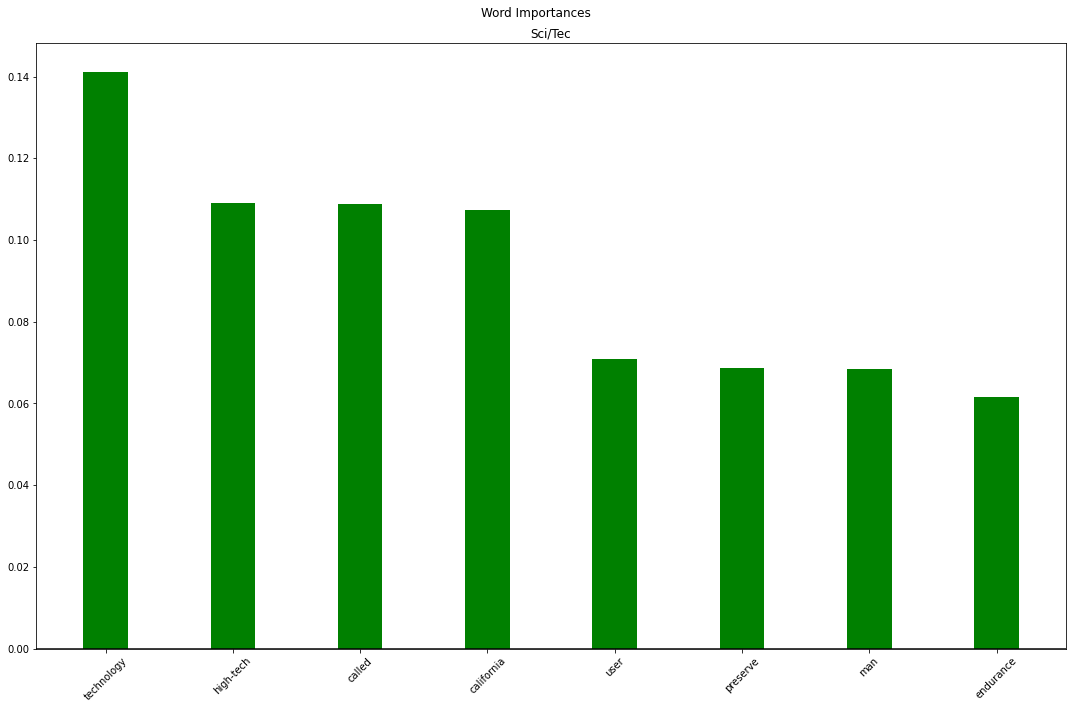

None

model: tree_ss_2_md_None


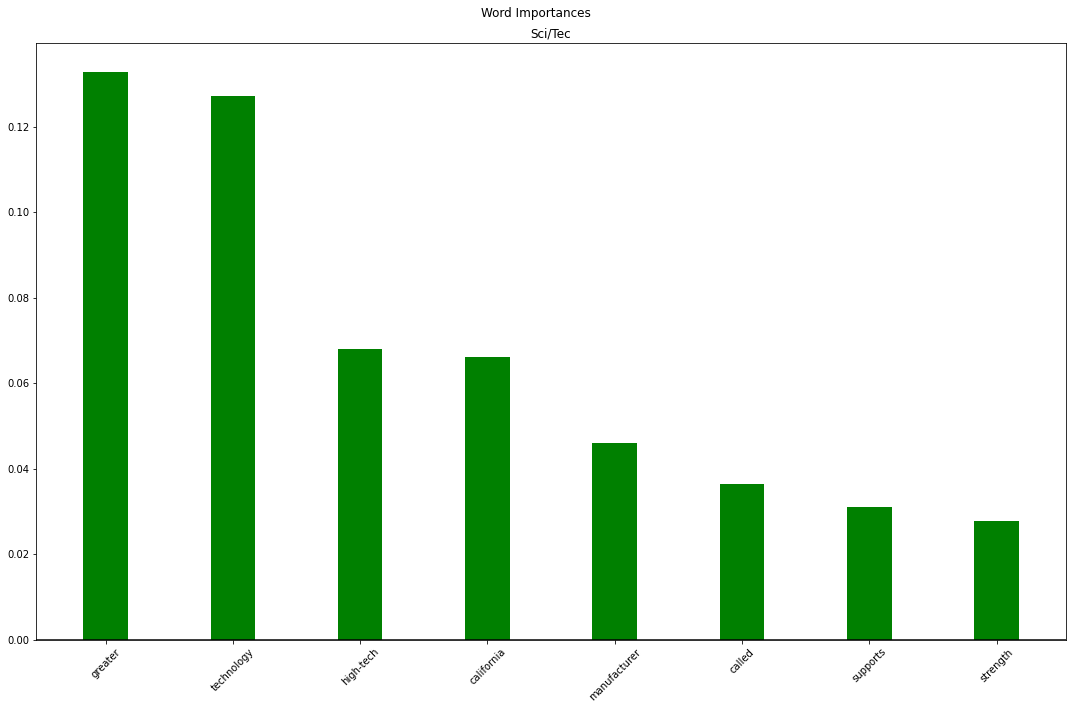

None

model: rf


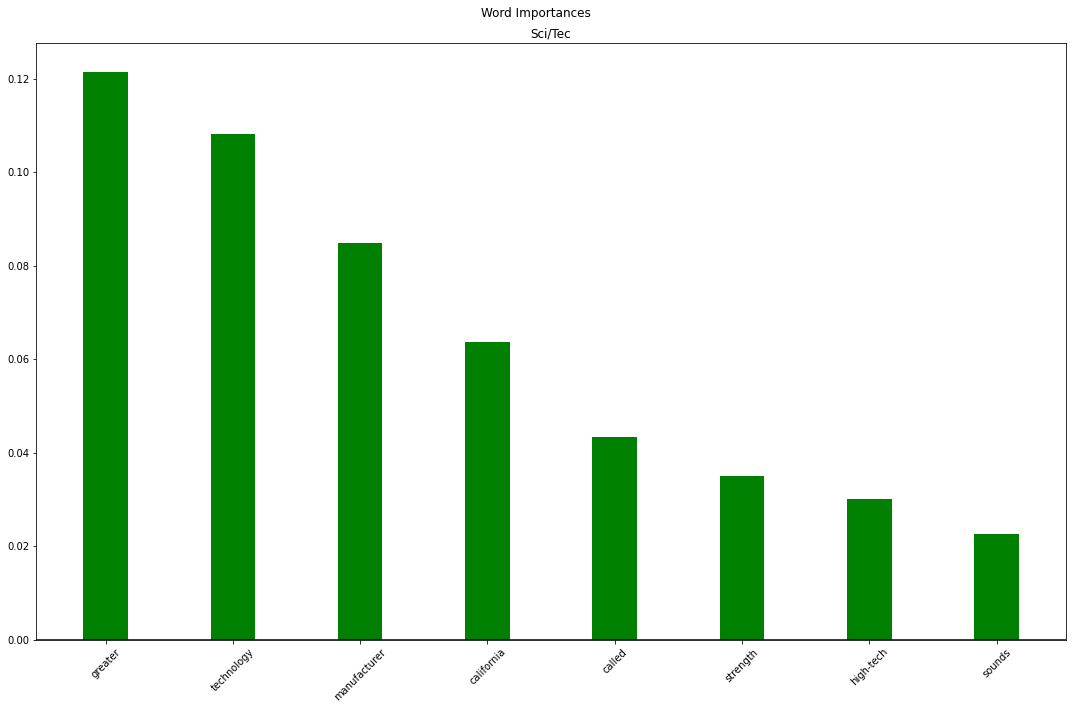

None

In [67]:
for p_model in param_model:
    print('model:', p_model)
    display(outs['temp']['p_model:'+str(p_model)].visualize_words({3: "Sci/Tec"}, 8, show_coefs='positive'))

In [68]:
#settings1 = [('p_feat:'+str(p_feat),'p_alpha:'+str(p_alpha)) for p_feat,p_alpha in itertools.product(param_feature,param_alpha)]
settings = [('temp', 'p_model:'+str(p_model)) for p_model in param_model]
idx, wrd = reformat_outs(text, settings, outs=outs, genre=3)
idx_anno, new_anno = reformat_anno(text, annotation)

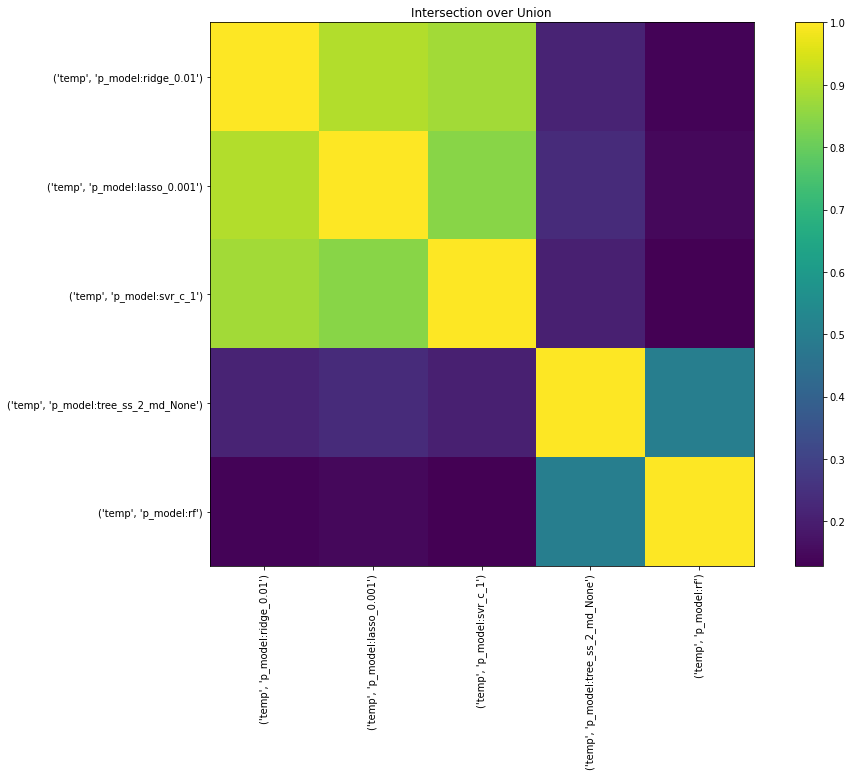

In [69]:
plot_array = np.ones((len(settings),len(settings)))
for i,j in itertools.permutations(range(len(settings)), 2):
    plot_array[i,j] = compare_outs(idx[i], idx[j])
plt.imshow(plot_array)
plt.colorbar()
plt.title('Intersection over Union')
l=list(range(len(settings)))
x=[settings[i] for i in range(len(settings))]

plt.gca().set_xticks(l)
plt.gca().set_xticklabels(x, rotation=90)
plt.gca().set_yticks(l)
plt.gca().set_yticklabels(x)
plt.show()

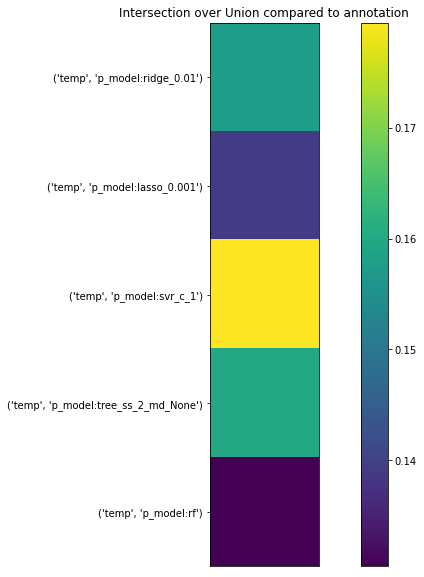

In [70]:
plot_array = np.ones((len(settings),1))
for i in range(len(settings)):
    plot_array[i] = compare_outs(idx[i], idx_anno)
plt.imshow(plot_array)
plt.colorbar()
plt.title('Intersection over Union compared to annotation')
l=list(range(len(settings)))
x=[settings[i] for i in range(len(settings))]

plt.gca().set_yticks(l)
plt.gca().set_yticklabels(x)
plt.gca().set_xticks([1])
plt.show()